<a href="https://colab.research.google.com/github/philipp-hellwig/evolution-language-simulation/blob/main/Agent_based_Model_Communication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agent-based Model

What are the conditions that are necessary for developing a predisposition for language? In this notebook, we will model the evolution of communication amongst agents.


### Model Assumptions

#### Agent Behaviour

- **Inheritance:** Agents are assumed to inherit a predisposition for how likely they are to communicate and whether they want to harm one another. This will determine the agents' priors:
$P(\text{communicate})$ and $P(\text{malintent})$.
These factors will be determined by the individual's inherited genome. Arbitrarily, I have decided that the DNA sequence is $98$ nucleotides long. The first half determines the prior to communicate, the second half determines the prior to act in bad faith (malintent).

In [1]:
import numpy as np
import warnings
from itertools import chain
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.distributions as td
import seaborn as sns
from tqdm import tqdm
import random

In [3]:
class Agent():
    nucleotides = ["a","t","c","g"]
    food_individual_consumption = 1.6
    food_sharing = 1.5
    food_stealing = 3
    food_decay = 1.75

    # used to adjust class variables above
    @classmethod
    def set_class_variables(cls, **kwargs):
        for key, value in kwargs.items():
            if hasattr(cls, key):
                setattr(cls, key, value)
            else:
                warnings.warn(f"Class has no attribute '{key}'")

    def __init__(self, mu: float, parents=None):
        self.parents = parents
        self.dna = np.random.choice(Agent.nucleotides, 90) if parents is None else self.inherit(parents, mu)
        self.malintent, self.communication = self.features_from_dna(self.dna)
        self.prior_malintent = self.malintent/(len(self.dna)/6)
        self.prior_communication = self.communication/(len(self.dna)/6)
        self.food_counter = 5 # initial amount of food reserves an individual is born with
        self.reputation = 1

    # inheritance method
    def inherit(self, parents: tuple, mu: float):
        # inheritance:
        child_dna = []
        for i in range(0, (len(parents[0].dna)-2), 3):
            child_dna.append(list(np.random.choice(parents).dna[i:i+3]))
        # random mutation:
        child_dna = list(chain(*child_dna))
        for i in range(len(child_dna)):
            if st.bernoulli(mu).rvs(1):
                child_dna[i] = random.choice(Agent.nucleotides)
        return child_dna

    # extract features from DNA
    def features_from_dna(self, dna: list):
        communication, malintent = 0, 0
        for i in range(0, len(dna), 3):
            if i < (len(dna)/2):
                # every occurrence of "c,c,t" counts as +1 to malintent feature
                if "".join(dna[i:i+3])=="cct":
                    communication += 1
            else:
                # every occurrence of "g,a,t" counts as +1 to communication feature
                if "".join(dna[i:i+3])=="gat":
                    malintent += 1
        return (malintent, communication)

    # food opportunity interaction:
    def found_food(self, other):
        # decide to communicate or not:
        if st.bernoulli(self.prior_communication).rvs(1):
            # other also has to be willing to communicate
            if st.bernoulli(other.prior_communication).rvs(1):
                # decide to try to steal food or not
                if st.bernoulli(self.prior_malintent).rvs(1):
                    # other has good intentions:
                    if not st.bernoulli(other.prior_malintent).rvs(1):
                        self.food_counter += Agent.food_stealing
                    # other also wants to steal the food:
                    else:
                        np.random.choice([self, other]).food_counter += Agent.food_stealing
                else:
                    if st.bernoulli(other.prior_malintent).rvs(1):
                        other.food_counter += Agent.food_stealing
                    else:
                        # share food:
                        self.food_counter += Agent.food_sharing
                        other.food_counter += Agent.food_sharing
                        # increase reputation:
                        self.reputation += 1
                        other.reputation += 1
            else:
                self.food_counter += Agent.food_individual_consumption
        else:
            self.food_counter += Agent.food_individual_consumption

    def starve(self):
        starved = self.food_counter < 0
        return starved

    def apply_food_decay(self):
        self.food_counter -= Agent.food_decay

    def __str__(self):
        return(
            f"Agent (Parents: {self.parents})\n"
            "##### Features #####\n"
            f"Communication: {self.communication}\n"
            f"Malintent: {self.malintent}\n"
            f"Reputation: {self.reputation}\n"
        )

For example, we can create an agent without inheritance, who gets assigned a random DNA string:

In [4]:
individual = Agent(mu=0.001)
print(individual)
print(f"Length DNA = {len(individual.dna)}\nDNA: {' '.join(individual.dna)}")

Agent (Parents: None)
##### Features #####
Communication: 0
Malintent: 0
Reputation: 1

Length DNA = 90
DNA: g a g g c a g g g a a c c t c a t g a a t a t c a a c t t t g c a t t c a g g g a c g g a t t c g t a t g c t g c g c t c g c a t a g c a g t g t t g g a a g g t g t g t a c c a a


### Inheritance Example
We can create a child from two Agent instances by using the parents argument in the instantiate method. The child's DNA is a result of random choices of DNA triplets from either the father or the mother

In [5]:
mu = 0.01
mother = Agent(mu)
father = Agent(mu)
child = Agent(mu, parents=(mother, father))

print("Father:")
print(" ".join(father.dna))
print("Mother:")
print(" ".join(mother.dna))
print("Child:")
print(" ".join(child.dna))

Father:
t g c t t g t a c a g t c t g g a t a a a t g t a g c a a g c g t g c t c t c c t a t t g c a a a a t c c a g c c a g a c t c g c c g a c c g a a t c t g c c a t t t g c t c t c g
Mother:
c t t t a c t g t t t t t g t g t t a a c t a g t g c g g a a g t c c a g a t g t t g c c g t a t a g g c c t t t t a c c a c g a a c t c a g c c a g g g g a t a t a a t t a a g g
Child:
c t t t a c t a c a g t c t g g a t a a a t g t a g c g g a a g t c c a c t c g t t g c c g t a t a g c c a t t t t a c c a c g a a c t c a g c a t c g g g a t a t a a c t c t c g


### Potential Strategies

Before we run the simulation, let us consider how different strategies affect survival chances.

- Strategy 1: Never communicate, always eat alone
- Strategy 2: Always communicate, never try to steal food
- Strategy 3: Always communicate, alway try to steal food

Strategy 2 and Strategy 3 depend on the behaviour of others, therefore we should consider different proportions of others applying Strategy 2 or 3.

Let's assume that during each life cycle an individual has 30 food opportunities (+ the opportunities they get by chance where they communicate to others and they communicate back) and that the population size stays at 30.

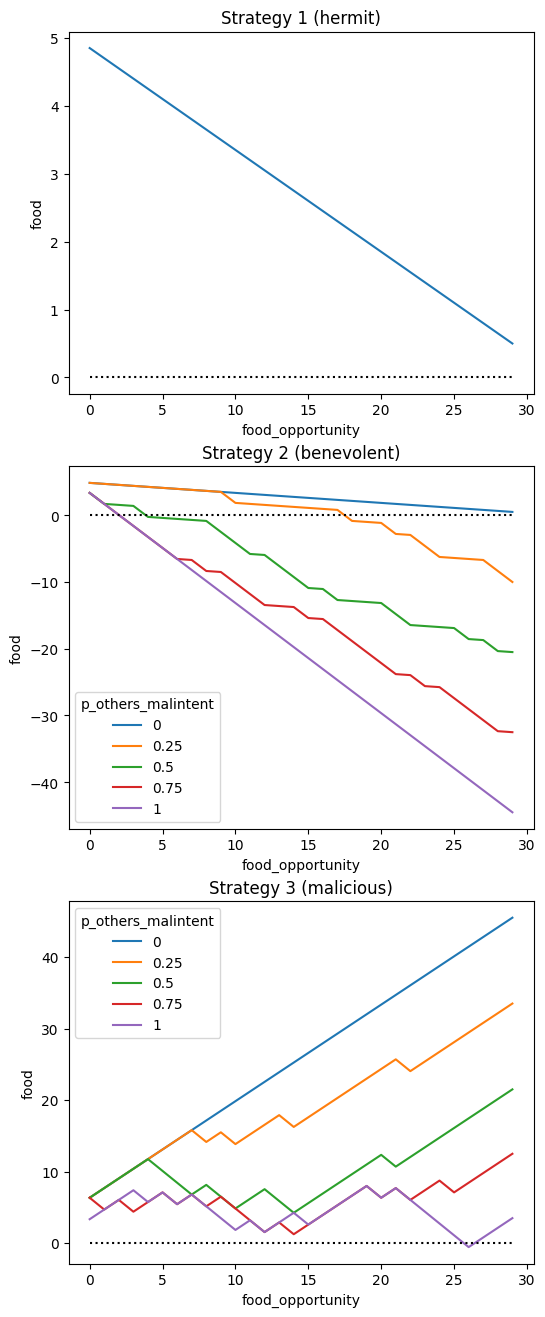

In [6]:
initial_food = 5
food_decay = 1.65

# Strategy 1
strat_1 = []
food_count = initial_food
for _ in range(30):
    food_count = food_count + 1.5 - food_decay
    strat_1.append(food_count)

# Strategy 2
strat_2 = pd.DataFrame(columns=["food_opportunity", "p_others_malintent", "food"])
for p_others in [0, 0.25, 0.5, 0.75, 1]:
    food_count = initial_food
    for i in range(30):
        food_count -= food_decay
        if st.bernoulli(p_others).rvs(1):
            pass
        else:
            food_count += 1.5
        strat_2.loc[len(strat_2.index),:] = (i, str(p_others), food_count)

# Strategy 3
strat_3 = pd.DataFrame(columns=["food_opportunity", "p_others_malintent", "food"])
for p_others in [0, 0.25, 0.5, 0.75, 1]:
    food_count = initial_food
    for i in range(30):
        food_count -= food_decay
        if st.bernoulli(p_others).rvs(1):
            if st.bernoulli(0.5).rvs(1):
                food_count += 3
        else:
            food_count += 3
        strat_3.loc[len(strat_3.index),:] = (i, str(p_others), food_count)

# plot strategies:
fig, ax = plt.subplots(3,1, figsize=(6,16))
_ = ax[0].plot(strat_1)
_ = ax[0].set_title("Strategy 1 (hermit)")
_ = ax[0].set_xlabel("food_opportunity")
_ = ax[0].set_ylabel("food")
_ = ax[0].hlines(0, 0, 29, color="black", linestyles="dotted")
_ = sns.lineplot(data=strat_2, x="food_opportunity", y="food", hue="p_others_malintent", ax=ax[1])
_ = ax[1].set_title("Strategy 2 (benevolent)")
_ = ax[1].hlines(0, 0, 29, color="black", linestyles="dotted")
_ = sns.lineplot(data=strat_3, x="food_opportunity", y="food", hue="p_others_malintent", ax=ax[2])
_ = ax[2].set_title("Strategy 3 (malicious)")
_ = ax[2].hlines(0, 0, 29, color="black", linestyles="dotted")

If agents want to maximize for food only, they should try to communicate as much as possible and they should try to steal food after cooperating for obtaining food (malintent).

# Simulations

### Parameters
- **number of generations**: how many generations the simulation runs
- **population size**: how many individuals are in a generation
- **food opportunities**: how many food opportunities a generation has
- $\mathbf{\mu}$: mutation chance per nucleotide.


|  | Communication | Malintent |
| --- | --- | --- |
| Cost | lower chance of survival | no reputation gain/ lower reproductive chances  |
| Benefit | reputation gain/ higher reproductive chances | higher chance of survival |

The reproductive chances depend on their food counter and their reputation. An agent gains reputation based on their food counter. Additionally, if they communicate positively, they also gain reputation.
$$chances_i = \frac{reputation_i}{\sum_{a \in agents} reptutation_a}$$

For example, if the agents' reputations are 9, 4, 5, 2, the reproductive chances are shown in the graph on the left; if reputations are 5, 5, 5, 5, 5 the reproductive chances are shown in the graph on the right.

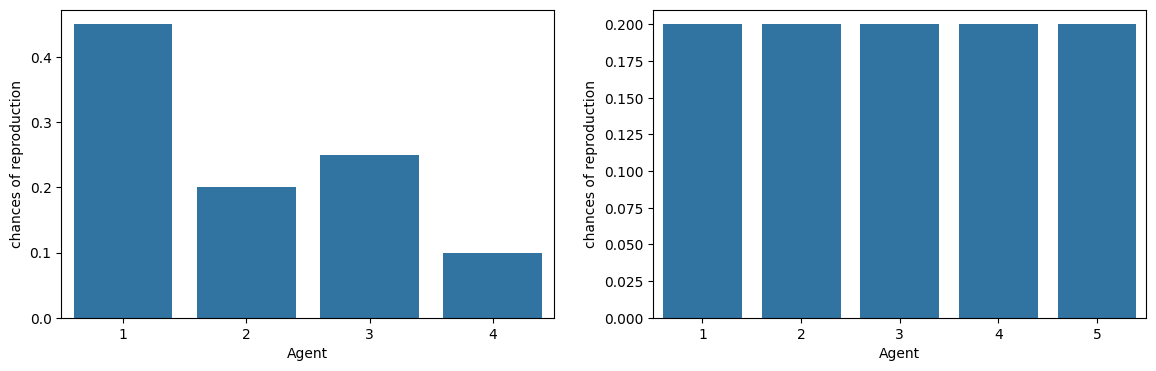

In [7]:
example_reputations = [[9,4,5,2],[5,5,5,5,5]]
fig, ax = plt.subplots(1,2, figsize=(14,4))
for i, reputations in enumerate(example_reputations):
    total_rep = np.sum(reputations)
    _ = sns.barplot(x=range(1,len(reputations)+1), y=td.Categorical(probs=torch.Tensor([reputation/total_rep for reputation in reputations])).probs, ax=ax[i])
    _ = ax[i].set_xlabel("Agent")
    _ = ax[i].set_ylabel("chances of reproduction")

In [12]:
def reproduce(population: list[Agent], mu: float, reputation=False, size=1):
    offspring = []
    if reputation:
        if len(population) > 2:
            total_rep = np.sum([agent.reputation for agent in population])
            repr_chances = td.Categorical(probs=torch.Tensor([agent.reputation/total_rep for agent in population])) # agents with higher reputation have higher chances of reproduction
            for _ in range(size):
                parent1 = population[int(repr_chances.sample())]
                while True:
                    parent2 = population[int(repr_chances.sample())]
                    if parent1 != parent2:
                        break
                offspring.append(Agent(mu, parents=(parent1, parent2)))
    else:
        if len(population) > 2:
            for _ in range(size):
                parent1 = random.choice(population)
                while True:
                    parent2 = random.choice(population)
                    if parent1 != parent2:
                        break
                offspring.append(Agent(mu, parents=(parent1, parent2)))
    return offspring


def simulate_generation(num_food_opportunities: int, num_generations:int, population_size:int, reputation_reproduction: bool, mu=0.01, **class_variables):
    # adjust class variables if given:
    Agent.set_class_variables(**class_variables)

    # set up df to collect data:
    features = pd.DataFrame(columns=["generation", "feature", "type"])

    #initialize first generation
    current_gen = [Agent(mu) for _ in range(population_size)]

    for gen in tqdm(range(1, (num_generations+1))):
        initial_generation_population_size = len(current_gen)
        for food_opportunity in range(1, (num_food_opportunities+1)):
            # apply food decay and food opportunities:
            for agent in current_gen:
                agent.apply_food_decay()
                agent.found_food(other=np.random.choice(current_gen))

            # starve agents every 5 generations if their food_counter drops too low:
            if food_opportunity % 5 == 0:
                current_gen = [agent for agent in current_gen if not agent.starve()]

        # record population level features/ statistics:
        communication, malintent = [],[]
        for agent in current_gen:
            communication.append(agent.communication)
            malintent.append(agent.malintent)
        
        features.loc[len(features.index)] = [gen, np.mean(communication) if len(current_gen) > 0 else None, "communication"]
        
        features.loc[len(features.index)] = [gen, np.mean(malintent) if len(current_gen) > 0 else None, "malintent"]

        # simulate reproduction with reputation:
        current_gen = reproduce(current_gen, mu, reputation=reputation_reproduction, size=population_size)

    return features

def plot_simulation_stats(simulation_stats):
    fig, ax = plt.subplots(1,2, figsize=(14,6))
    _ = sns.lineplot(data=simulation_stats.loc[:, simulation_stats.columns!="starvation"], ax=ax[0])
    _ = ax[0].set_xlabel("Generation")
    _ = ax[0].set_title("Features")
    _ = ax[0].set_ylim(0,17)
    _ = ax[1].scatter(simulation_stats.index, simulation_stats["starvation"])
    _ = ax[1].set_xlabel("Generation")
    _ = ax[1].set_title("Starvation")
    _ = ax[1].hlines(28, 0, 200, color="black", linestyles="dotted")
    _ = ax[1].legend(["starvation", "extinction threshold"])
    plt.show()

def plot_averaged_simulations(simulations: list[pd.DataFrame]):
    concatenated = pd.concat(simulations)
    _ = sns.lineplot(data=concatenated, x="generation", y="feature", hue="type", errorbar=("se", 1))
    _ = plt.ylim(0,17)
    plt.show()

## Reputation-based Partner Choice

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 30/30 [3:08:25<00:00, 376.84s/it]


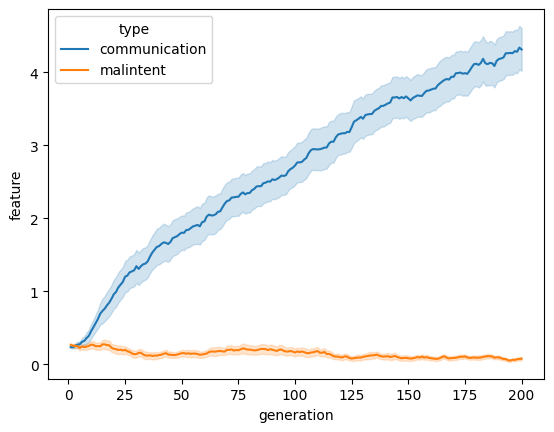

In [65]:
# Simulation with reputation-based reproduction
rbpc_sims = []
for _ in tqdm(range(30)):
    rbpc_sims.append(simulate_generation(num_food_opportunities=30, num_generations=200, population_size=30, reputation_reproduction=True))
plot_averaged_simulations(rbpc_sims)

100%|██████████| 200/200 [11:42<00:00,  3.51s/it]


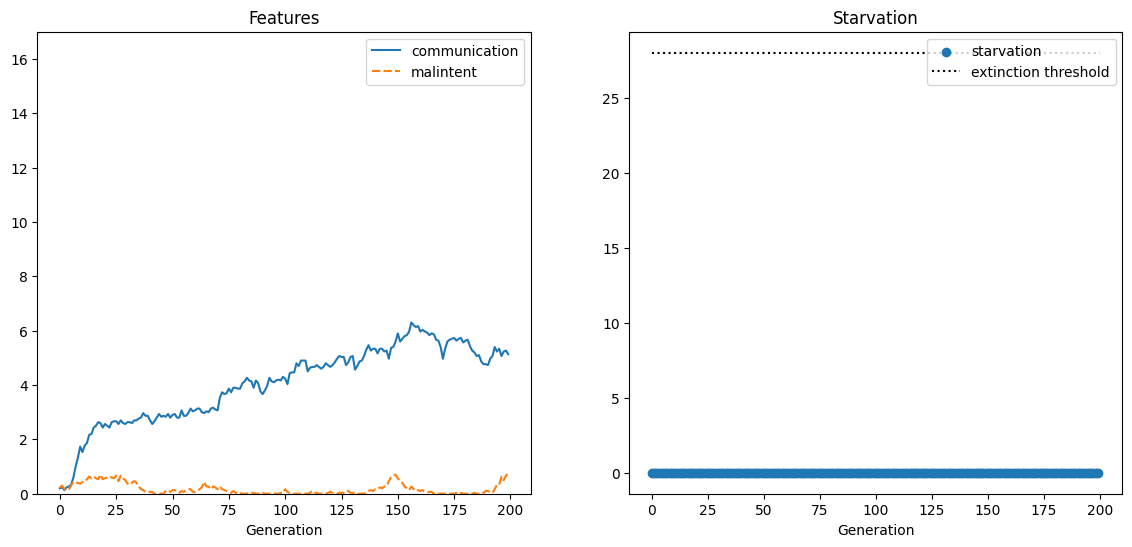

In [29]:
# Simulation with reputation-based reproduction
sim_reputation = simulate_generation(num_food_opportunities=30, num_generations=200, population_size=30, reputation_reproduction=True)
plot_simulation_stats(sim_reputation)


----------------------------------------------------Food decay = 1.5----------------------------------------------------



100%|██████████| 200/200 [11:26<00:00,  3.43s/it]


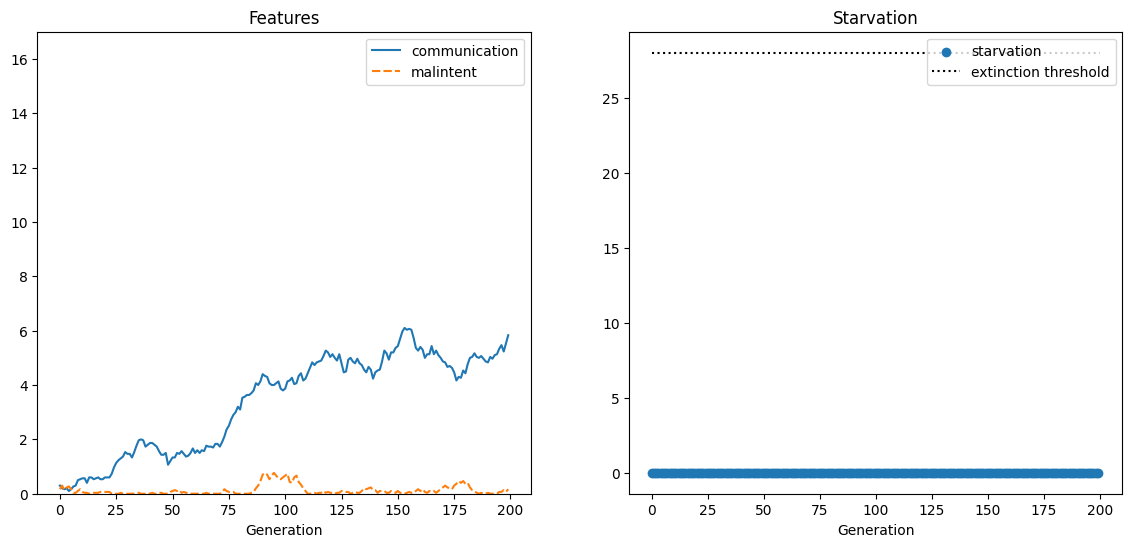


----------------------------------------------------Food decay = 1.7----------------------------------------------------



100%|██████████| 200/200 [11:01<00:00,  3.31s/it]


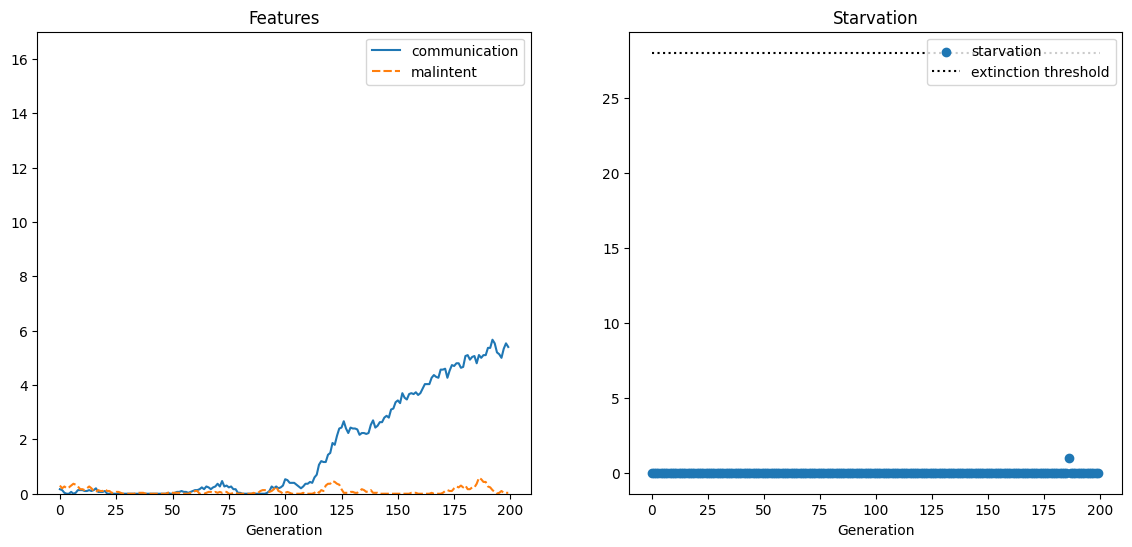


---------------------------------------------------Food decay = 1.75----------------------------------------------------



100%|██████████| 200/200 [12:23<00:00,  3.72s/it]


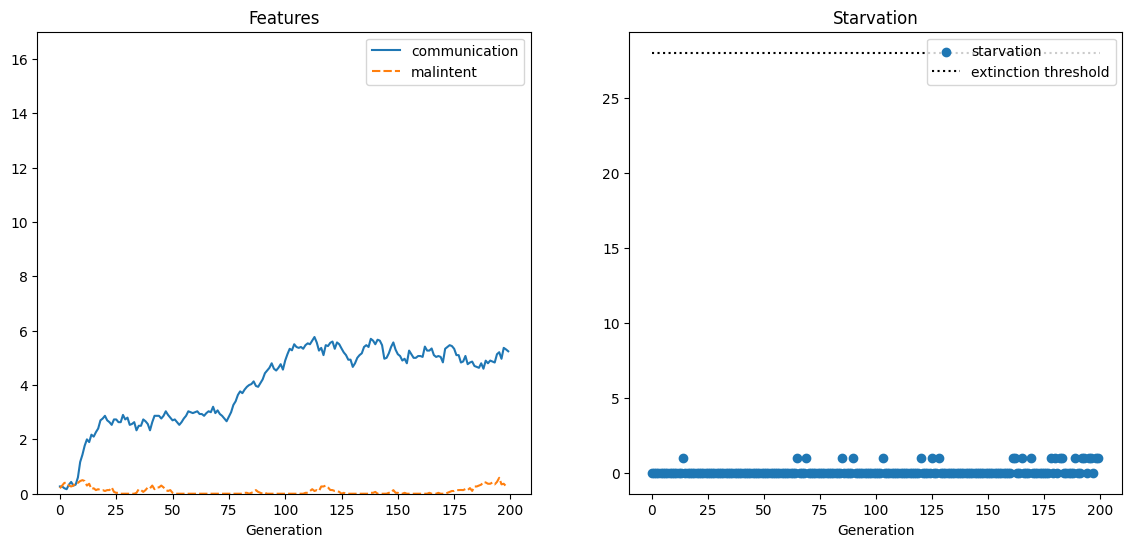


----------------------------------------------------Food decay = 1.8----------------------------------------------------



100%|██████████| 200/200 [00:01<00:00, 140.78it/s]


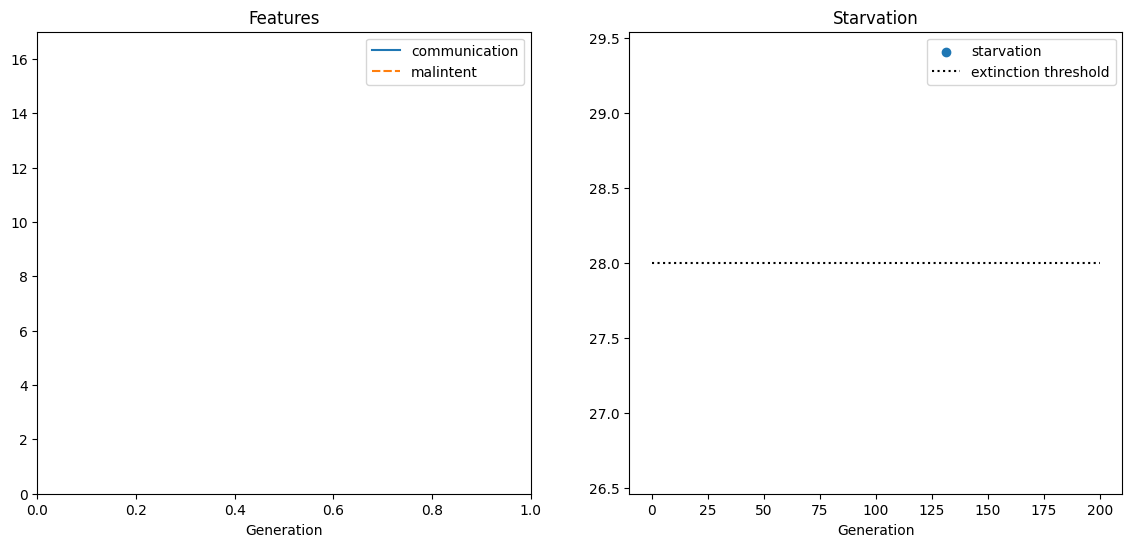

In [30]:
# Experimenting with different food_decays:

simulations = {}  # food decay: simulation data}
food_decays = [1.5, 1.7, 1.75, 1.8]
for decay in food_decays:
    f_decay = f"Food decay = {decay}"
    print(f'\n{f_decay:-^120}\n')
    sim_reputation = simulate_generation(num_food_opportunities=30, num_generations=200, population_size=30, reputation_reproduction=True, food_decay=decay)
    plot_simulation_stats(sim_reputation)
    simulations[decay] = sim_reputation

In [31]:
decay_df = pd.DataFrame(columns=["food_decay", "communication", "malintent", "starvation"])
for key, value in simulations.items():
    value["food_decay"] = key
    value["generation"] = value.index
    decay_df = pd.concat([decay_df, value])


In [32]:
import plotly.express as px

fig = px.line_3d(decay_df, x="food_decay", y="generation", z="communication", color='food_decay')
fig.show()


------------------------------------------------Food opportunities = 10-------------------------------------------------



100%|██████████| 200/200 [11:18<00:00,  3.39s/it]


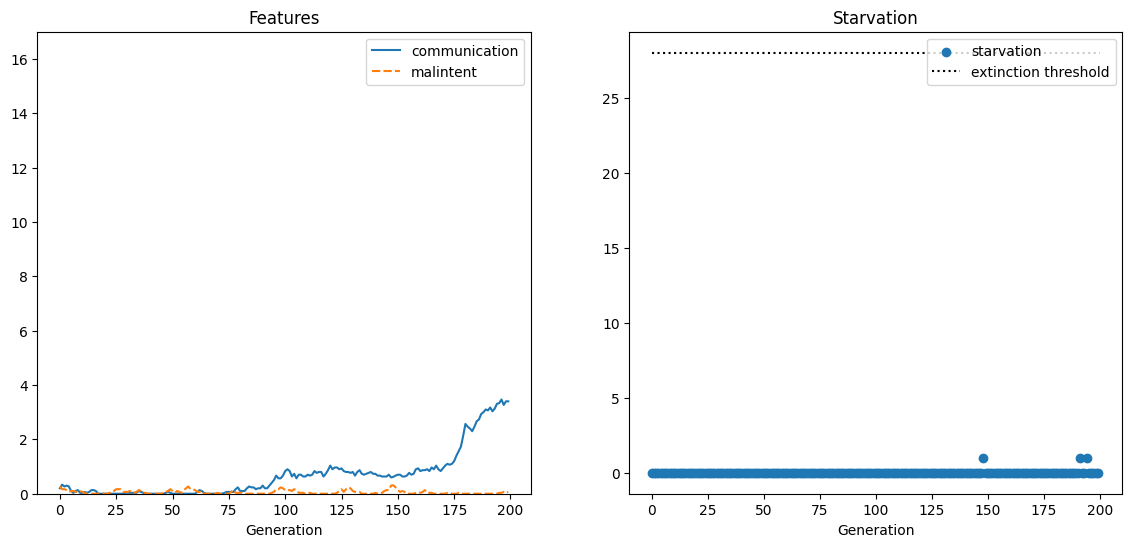


------------------------------------------------Food opportunities = 30-------------------------------------------------



100%|██████████| 200/200 [11:18<00:00,  3.39s/it]


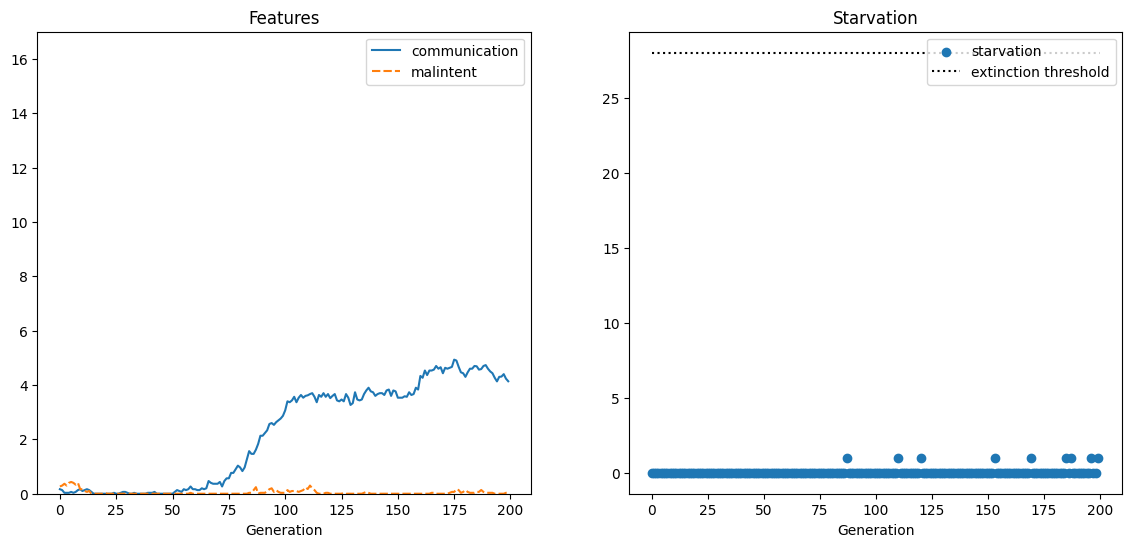


------------------------------------------------Food opportunities = 50-------------------------------------------------



100%|██████████| 200/200 [11:50<00:00,  3.55s/it]


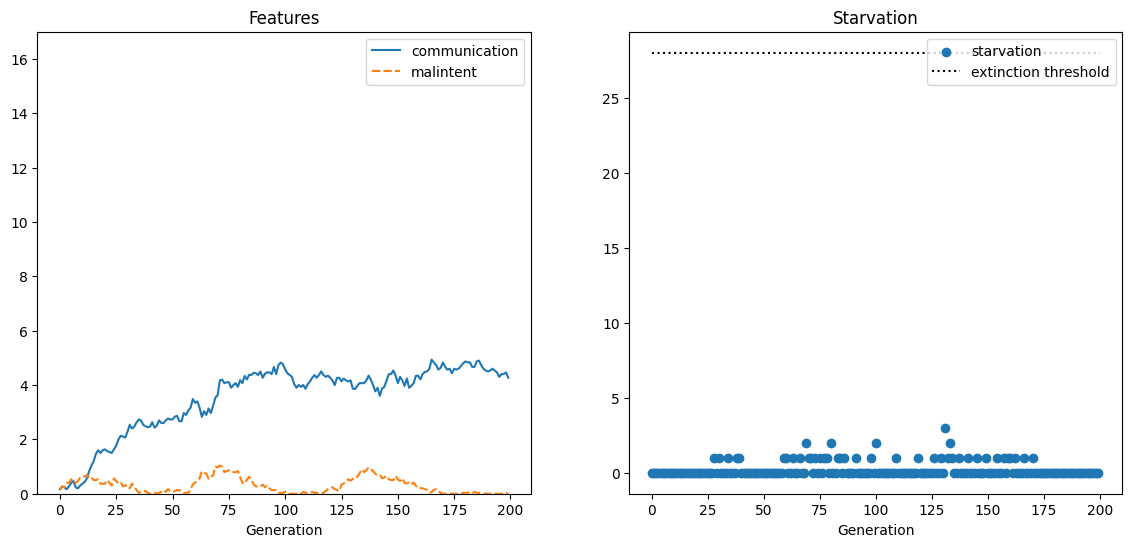


------------------------------------------------Food opportunities = 100------------------------------------------------



100%|██████████| 200/200 [10:49<00:00,  3.25s/it]


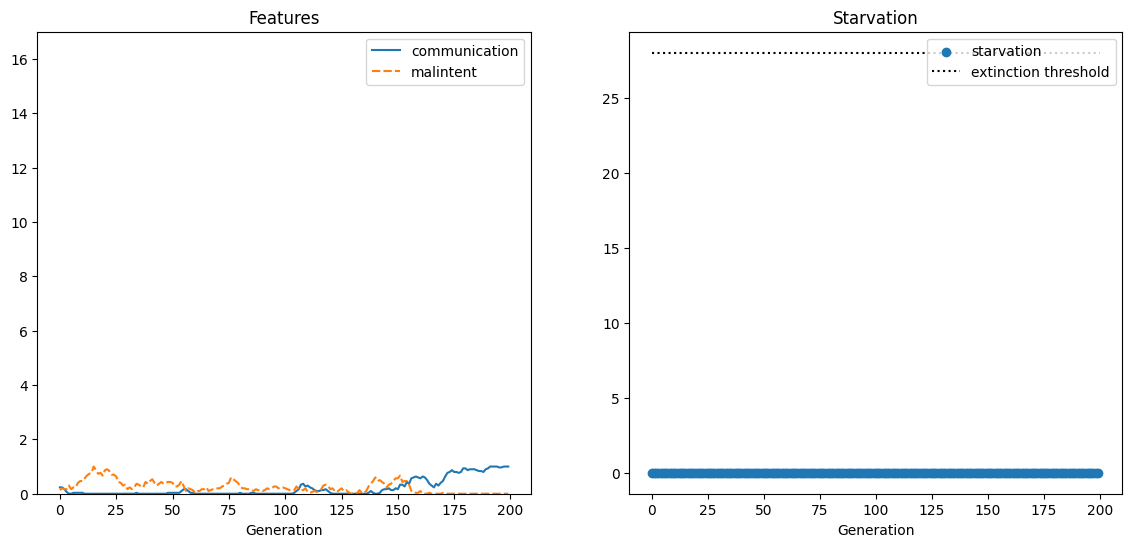


------------------------------------------------Food opportunities = 200------------------------------------------------



100%|██████████| 200/200 [11:20<00:00,  3.40s/it]


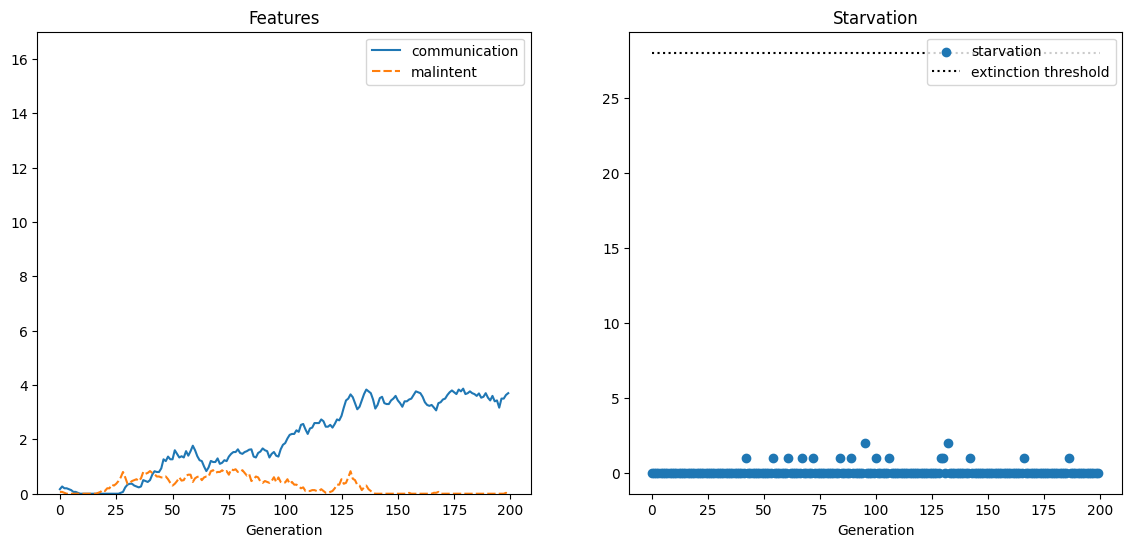


------------------------------------------------Food opportunities = 500------------------------------------------------



100%|██████████| 200/200 [11:20<00:00,  3.40s/it]


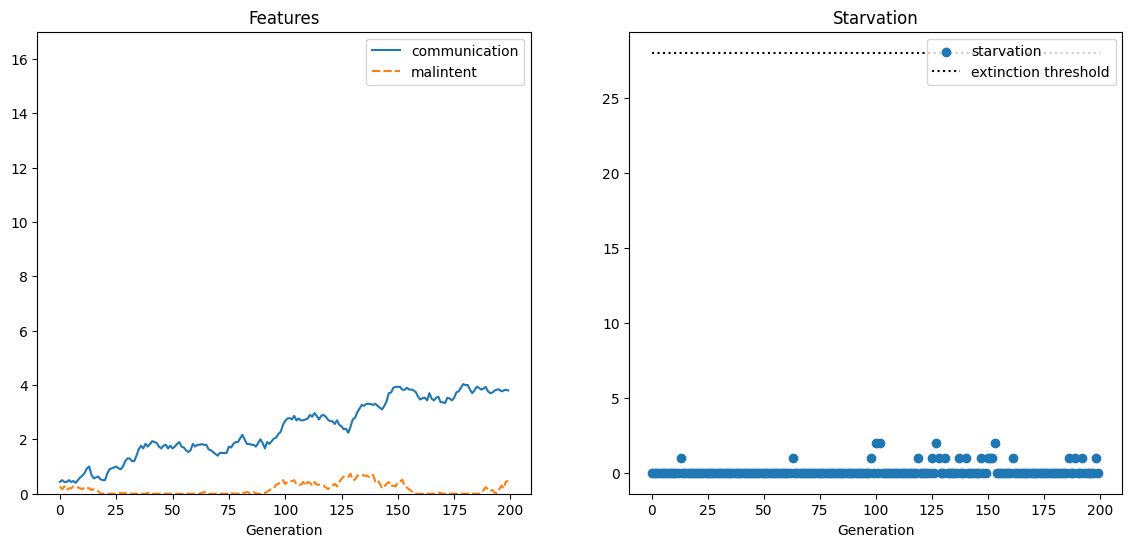

In [45]:
# experimenting with different number of food opportunities:

simulations = {}  # food decay: simulation data}
food_opportunities = [10, 30, 50, 100, 200, 500]
for opportunity in food_opportunities:
    f_opportunity = f"Food opportunities = {opportunity}"
    print(f'\n{f_opportunity:-^120}\n')
    sim_reputation = simulate_generation(num_food_opportunities=30, num_generations=200, population_size=30, reputation_reproduction=True, food_decay=1.75)
    plot_simulation_stats(sim_reputation)
    simulations[opportunity] = sim_reputation

## Indirect Reciprocity
The previous simulations were partner-choice based reputation models. Another approach is indirect reciprocity: Reputation here does not influence being selected as a sexual partner but rather agents that have helped others (and thus gained reputation) are more likely to be helped by others in the future.

Concretely, this means that we can apply the categorical distribution based on reputation to the chances of being selected as a communication partner rather than a sexual one.

In [7]:
def choose_communication_partner(agent_self: Agent, population: list[Agent]):
    total_rep = np.sum([agent.reputation for agent in population])
    coop_chances = td.Categorical(probs=torch.Tensor([agent.reputation/total_rep for agent in population])) # agents with higher reputation have higher chances of reproduction
    other = population[int(coop_chances.sample())]
    return other

def simulate_ir_evolution(num_food_opportunities: int, num_generations:int, population_size:int, mu=0.01, **class_variables):
    # adjust class variables if given:
    Agent.set_class_variables(**class_variables)

    # set up df to collect data:
    features = pd.DataFrame(columns=["generation", "feature", "type"])

    #initialize first generation
    current_gen = [Agent(mu) for _ in range(population_size)]

    for gen in tqdm(range(1, (num_generations+1))):
        initial_generation_population_size = len(current_gen)
        for food_opportunity in range(1, (num_food_opportunities+1)):
            # apply food decay and food opportunities:
            for agent in current_gen:
                agent.apply_food_decay()

                # apply indirect reciprocity for cooperation partner choice:
                agent.found_food(other=choose_communication_partner(agent_self=agent, population=current_gen))

            # starve agents every 5 generations if their food_counter drops too low:
            if food_opportunity % 5 == 0:
                current_gen = [agent for agent in current_gen if not agent.starve()]

        # record population level features/ statistics:
        communication, malintent = [],[]
        for agent in current_gen:
            communication.append(agent.communication)
            malintent.append(agent.malintent)
            
        features.loc[len(features.index)] = [gen, np.mean(communication) if len(current_gen) > 0 else None, "communication"]
        features.loc[len(features.index)] = [gen, np.mean(malintent) if len(current_gen) > 0 else None, "malintent"]

        # simulate reproduction without reputation:
        current_gen = reproduce(current_gen, mu, reputation=False, size=population_size)

    return features

In [8]:
# Simulation with reputation-based reproduction
ir_sims = []
for _ in tqdm(range(30)):
    ir_sims.append(simulate_ir_evolution(num_food_opportunities=30, num_generations=200, population_size=30))
plot_averaged_simulations(ir_sims)

100%|██████████| 30/30 [3:50:19<00:00, 460.64s/it]


NameError: name 'rbpc_sims' is not defined

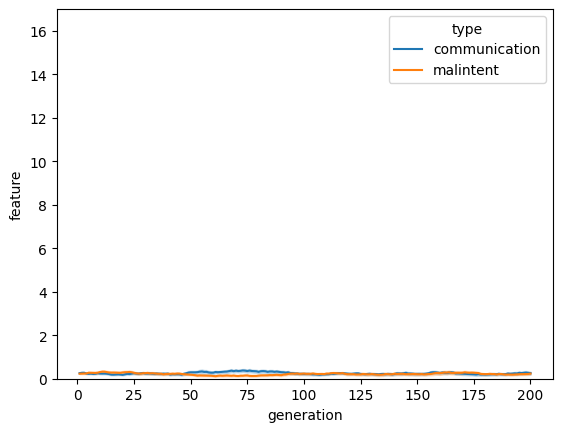

In [13]:
plot_averaged_simulations(ir_sims)


----------------------------------------------------Food decay = 1.5----------------------------------------------------



100%|██████████| 200/200 [11:23<00:00,  3.42s/it]


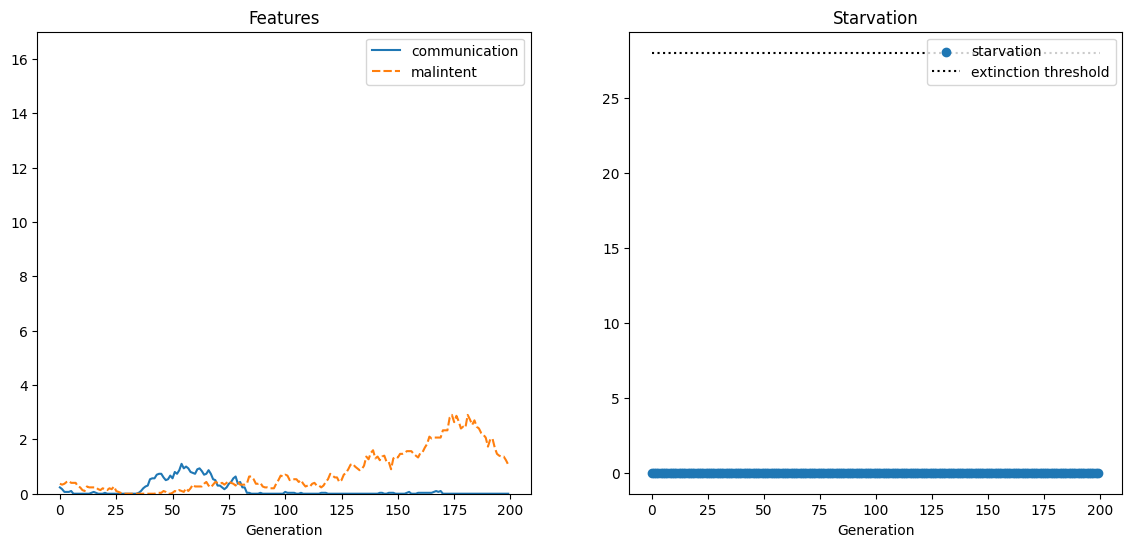


----------------------------------------------------Food decay = 1.7----------------------------------------------------



100%|██████████| 200/200 [11:25<00:00,  3.43s/it]


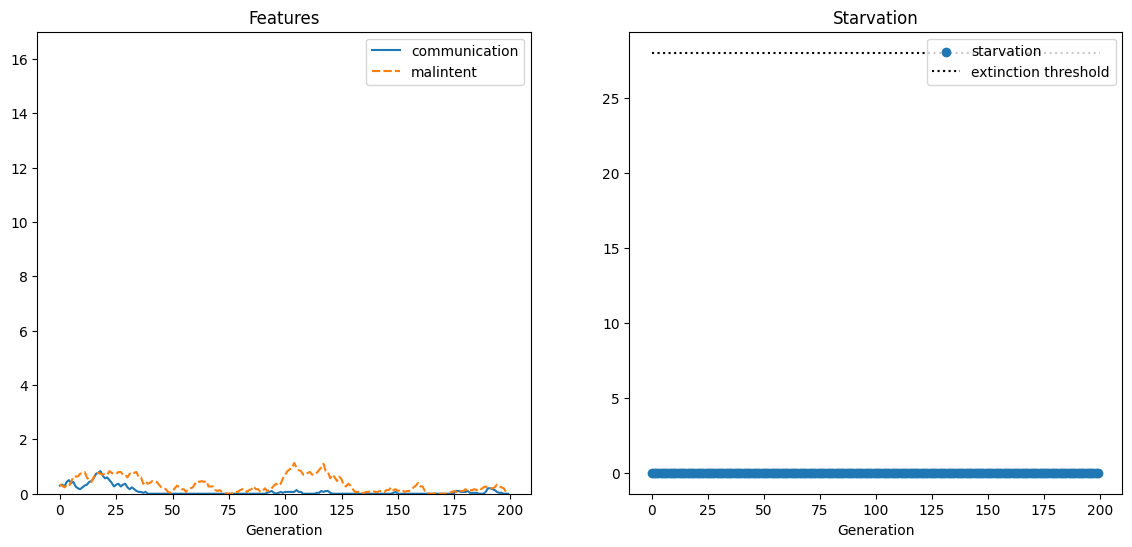


---------------------------------------------------Food decay = 1.75----------------------------------------------------



100%|██████████| 200/200 [11:30<00:00,  3.45s/it]


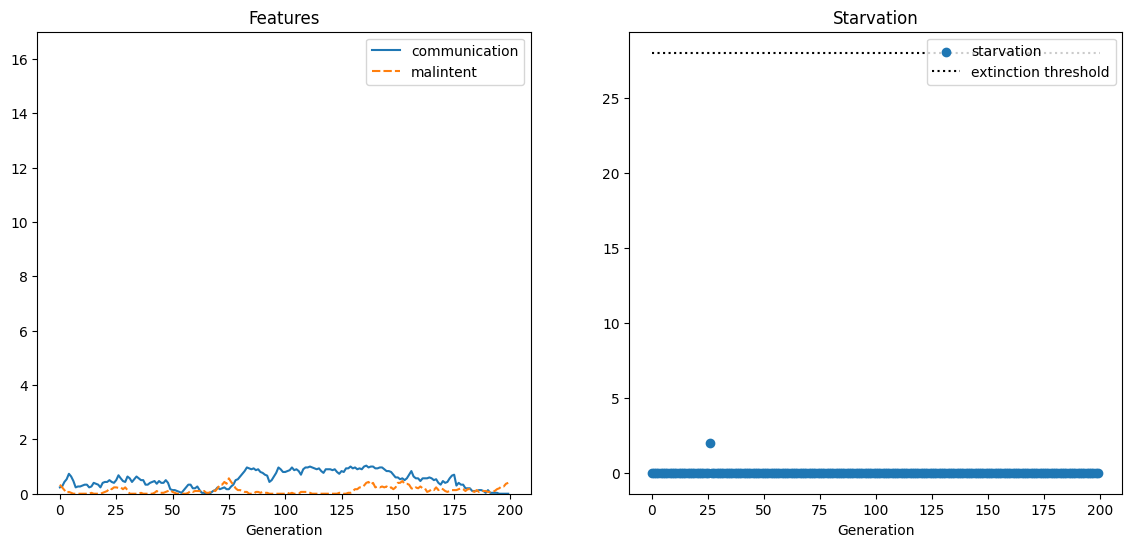


----------------------------------------------------Food decay = 1.8----------------------------------------------------



100%|██████████| 200/200 [00:01<00:00, 146.77it/s]


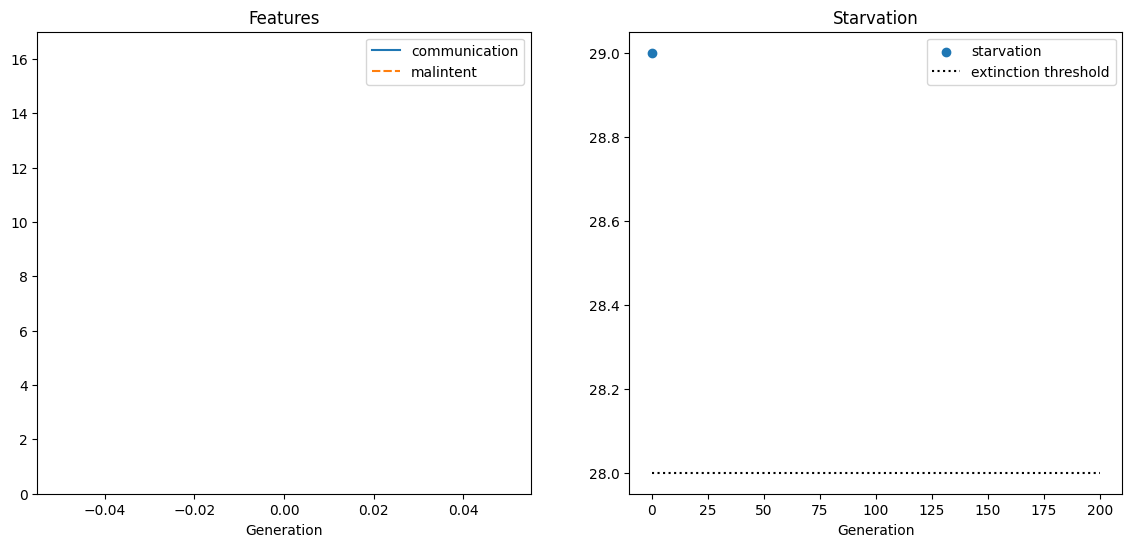

In [35]:
# Experimenting with different food_decays:

ir_simulations = {}  # food decay: simulation data
food_decays = [1.5, 1.7, 1.75, 1.8]
for decay in food_decays:
    f_decay = f"Food decay = {decay}"
    print(f'\n{f_decay:-^120}\n')
    sim_ir = simulate_ir_evolution(num_food_opportunities=30, num_generations=200, population_size=30, food_decay=decay)
    plot_simulation_stats(sim_ir)
    ir_simulations[decay] = sim_ir